<h2 id="intro">Introduction</h2>

You know what's cool in analyzing macroeconomic data? You can easily say "it will save them billions of dollars," and in many cases, you will be right. The macroeconomic scale allows us to easily feel the usefulness (or harmfulness) of the models we have build. If you also like this sense of importance, join me in my attempt today to discover a recession in African countries.

So, what's a [recession](https://en.wikipedia.org/wiki/Recession)? Generally, it is a decline in economic activity lasting more than a few months. More precisely, a recession is usually spoken of in the case of prolonged stagnation or fall in GDP, where GDP is an economic parameter that reflects the value of all goods and services produced per year in all sectors of the economy on the territory of the country. The emergence of recessions is usually associated with a general decline in demand for goods and services. Since any economy behaves in cycles, successively going through the stages of growth and decline, this is a fairly common situation.

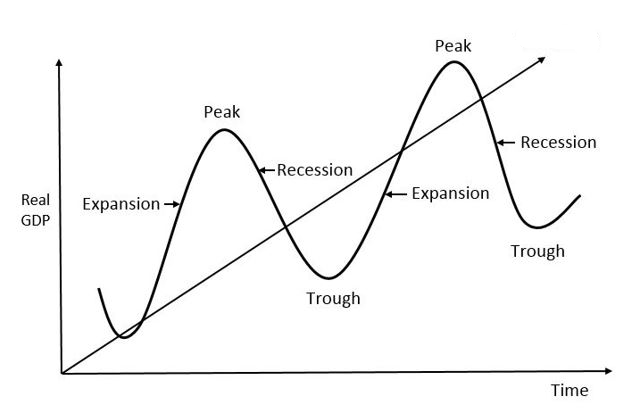

However, even if it's common it isn't good. Reducing the demand for goods and services entails a reduction in their production, which leads to the fact that companies lose money and their employees lose their jobs. This, of course, can lead to an even greater decrease in demand, as a result of which the situation will worsen. Therefore, to remove the economy from a state of recession, governments usually take certain measures, in particular, increasing their expenses and reducing taxes.

Thus, we can say that if you are from a government, investment fund or an international company, it will be very important for you to know whether the economy of the country you are interested in is in a state of recession.

A few words about the success criteria of the model. When I've started this analysis, I thought I need to build a model as accurate as possible. However, as we soon will see, imbalance in target variable classes and the small size of a dataset leads us to search for a compromise between the accuracy of determining the recession and the accuracy of determining the absence of a recession. The optimal relationship between them will depend on the cost of the mistake in both cases, which is difficult for me to evaluate due to poor knowledge of the domain. Reflecting on how this model can be used, I settled on a conservative strategy: the accuracy of determining the absence of a recession should be quite high (I would say at least 85%), and the accuracy of determining a recession should be as high as possible.

Before we will jump into analysis, I've wanted to thank Chiri for posting this great dataset and making this project possible.

<h2 id="data_libs">Loading data and libs</h2>

In [ ]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
pd.set_option('display.max_columns', 60)

In [ ]:
data = pd.read_csv('/kaggle/input/african-country-recession-dataset-2000-to-2017/africa_recession.csv')
data.head(10)

<h2 id="eda">Data analysis</h2>

Let's start with quickly reviewing some summary:

In [ ]:
data.info()

In [ ]:
'Dataset contains nulls: {}'.format(data.isnull().any().any())

Great! No missing values or categorical variables, so we don't need to waste any time handling it.

Here is our target variable:

In [ ]:
sns.distplot(a=data.growthbucket, kde=False)

As it was mentioned before, our target variable has significant class imbalance. We'll try to handle it later with [undersampling and oversampling techniques](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) (realisation provided by [imbalanced-learn library](https://imbalanced-learn.readthedocs.io/en/stable/index.html#)).

In [ ]:
plt.figure(figsize=(15, 13))
sns.heatmap(data=data.corr())

From the correlation matrix we could distinguish some feature clusters:
- [pl_c:fish] - represent price level
- [total_change:fish_change] - represent price level year-to-year change
- [ccon: mna] - correlation seem to be strong, but it's origin is unclear

We can now visualize some meaningful dependencies, using the correlations and what we know about a recession. This will include:
- rdana (since it represents total demand for all final marketed goods and services)
- emp 
- csh_g (government consumption)
- pl_c and total_change from clusters (to check how most of our data behaves)

In [ ]:
X_usampled, y_usampled = RandomUnderSampler(random_state=0).fit_resample(
    data.drop(columns=['growthbucket']), 
    data.growthbucket
)

under_X = pd.DataFrame(
    X_usampled, 
    columns=data.drop(columns=['growthbucket']).columns
)
under_y = pd.DataFrame(y_usampled, columns=['growthbucket'])
under_data = under_X.join(under_y)

In [ ]:
plt.figure(figsize=(15, 13))

plt.subplot(3, 2, 1)
sns.swarmplot(x=under_data.growthbucket, y=under_data.rdana)

plt.subplot(3, 2, 2)
sns.swarmplot(x=under_data.growthbucket, y=under_data.emp)

plt.subplot(3, 2, 3)
sns.swarmplot(x=under_data.growthbucket, y=under_data.csh_g)

plt.subplot(3, 2, 4)
sns.swarmplot(x=under_data.growthbucket, y=under_data.pl_c)

plt.subplot(3, 2, 5)
sns.swarmplot(x=under_data.growthbucket, y=under_data.total_change)

At this point rdana, csh_g and pl_c looks the most interesting. However, it's still hard to tell which exact features will we need to build a successful model. Instead, we'll try to train a preliminary model to highlight important features.

<h2 id="model">Model training</h2>

First, we need to develop a method to correctly measure model accuracy. Since our target variable has a class imbalance, we need something a little bit more complex than simple cross-validation. We'll use the following scheme:
- Randomly split data on train and test sets.
- Handle class imbalance in train set with one of three available methods: random undersampling, random oversampling or oversampling with SMOTE algorithm.
- Train and test the model, separately measuring the accuracy of determining a recession and accuracy of determining the absence of a recession.
- Repeat this multiple times and average the results.

In [ ]:
def test_with_tts(model, data, smpl_strat='rusamp', random_state=0):
    
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop('growthbucket', axis=1), 
        data.growthbucket, 
        random_state=random_state
    )
    if smpl_strat == 'rusamp':
        rus = RandomUnderSampler(random_state=0)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    elif smpl_strat == 'rosamp':
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    elif smpl_strat == 'smote':
        smote = SMOTE(random_state=0)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)        
    X_resampled = pd.DataFrame(X_resampled, columns=X_test.columns)
    
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_test)
    y_test.name = 'expected'
    results = pd.concat(
        [y_test, pd.Series(preds, index=y_test.index, name='got')], 
        axis=1
    )

    recessed = results[results.expected == 1]
    non_recessed = results[results.expected == 0]
    acc_rec = accuracy_score(recessed.expected, recessed.got)
    acc_nrec = accuracy_score(non_recessed.expected, non_recessed.got)
    
    return (acc_rec, acc_nrec)

def test_with_mc(n_it, model, data, smpl_strat='rusamp'):
    random.seed(0)
    
    results_rec = []
    results_nrec = []
    for i in range(n_it):
        r_r, r_n = test_with_tts(
            model, 
            data, 
            smpl_strat, 
            i*random.randint(0,1e2) # randomises train_test_split
        )
        results_rec.append(r_r)
        results_nrec.append(r_n)
    acc_rec = sum(results_rec)/len(results_rec)
    acc_nrec = sum(results_nrec)/len(results_nrec)
    return (acc_rec, acc_nrec)

In [ ]:
def print_acc_res(a_r):
    print('Recessed classification accuracy: {}%'.format(round(a_r[0], 2)))
    print('None-recessed classification accuracy: {}%'.format(round(a_r[1], 2)))

Next, let's test some models find which is best-performed. We'll check out XGBoost, RandomForest and Ridge.

Random undersampling is a simple and easy-to-understand strategy. However, in this particular case, it left us with ~80 rows in the dataset, which leads to low none-recessed-classification accuracy. Even if recessed-classification accuracy is good (and it usually is) this does not fit our success criteria.

In [ ]:
xgb_us_full = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0), 
    data, 
    smpl_strat='rusamp'
)

print_acc_res(xgb_us_full)

Oversampling strategies tend to improve none-recessed-classification accuracy and slightly worsen recessed-classification accuracy, which is a better fit for our success criteria. SMOTE is generally a little bit better than random oversampling.

In [ ]:
xgb_os_full = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0), 
    data, 
    smpl_strat='rosamp'
)

print_acc_res(xgb_os_full)

In [ ]:
xgb_smote_full = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0), 
    data, 
    smpl_strat='smote'
)

print_acc_res(xgb_smote_full)

XGBoost (especially with SMOTE) looks appropriate for our model.

In [ ]:
rf_us_full = test_with_mc(
    20, 
    RandomForestClassifier(random_state=0), 
    data, 
    smpl_strat='rusamp'
)

print_acc_res(rf_us_full)

In [ ]:
rf_os_full = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0), 
    data, 
    smpl_strat='rosamp'
)

print_acc_res(rf_os_full)

In [ ]:
rf_smote_full = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0), 
    data, 
    smpl_strat='smote'
)

print_acc_res(rf_smote_full)

Random Forest is almost as good as XGBoost, but I think XGBoost gives us a better compromise between none-recessed-classification accuracy and recessed-classification accuracy.

In [ ]:
rid_us_full = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0), 
    data, 
    smpl_strat='rusamp'
)

print_acc_res(rid_us_full)

In [ ]:
rid_os_full = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0), 
    data, 
    smpl_strat='rosamp'
)

print_acc_res(rid_os_full)

In [ ]:
rid_smote_full = test_with_mc(
    20, 
    RidgeClassifier(alpha=10.0, random_state=0), 
    data, 
    smpl_strat='smote'
)

print_acc_res(rid_smote_full)

Ridge works fine, but not as good as XGB and RF. So our choice is XGBoost with SMOTE oversampling strategy. Let's use it to highlight important features for us.

<h2 id="features">Extraction and engineering of important features</h2>

In order to extract important features we'll use permutation importances:

In [ ]:
X = data.drop(columns=['growthbucket'])
y = data.growthbucket

X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X, y)

model = XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0)
model.fit(X_resampled,y_resampled)
permi = PermutationImportance(model, random_state=0).fit(
    X_resampled,
    y_resampled
)
eli5.show_weights(permi, feature_names=X.columns.tolist(), top=100)

In [ ]:
important_columns = [
    'rdana',
    'cwtfp',
    'pl_x',
    'pl_c',
    'pl_n',
    'rwtfpna',
    'energy',
    'csh_r',
    'metals_minerals_change',
    'metals_minerals',
    'agriculture_change',
    'xr',
    'cn',
]
important_columns += ['growthbucket']

important_data = data[important_columns]

xgb_smote_imp = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0),
    important_data, 
    smpl_strat='smote'
)

print_acc_res(xgb_smote_imp)

Now let's see what we got:

rdana - "Real domestic absorption at constant 2011 national prices"

We knew that was coming, and this is consistent with our understanding of the recession mechanism.

In [ ]:
sns.swarmplot(x=under_data.growthbucket, y=under_data.rdana)

cwtfp - "Welfare-relevant TFP levels at current PPPs"

rwtfpna - "Welfare-relevant TFP at constant national prices"

TFP stands for Total Factor Productivity - economic parameter reflecting long-term technological changes and their impact on output. Its influence on the model can probably be explained by the technological lag of several African countries and its negative impact on economic development.

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.swarmplot(x=under_data.growthbucket, y=under_data.cwtfp)

plt.subplot(1, 2, 2)
sns.swarmplot(x=under_data.growthbucket, y=under_data.rwtfpna)

pl_x, pl_c, pl_n, energy, metals_minerals - these all reflect the price level:

In [ ]:
plt.figure(figsize=(15, 13))

plt.subplot(3, 2, 1)
sns.swarmplot(x=under_data.growthbucket, y=under_data.pl_x)

plt.subplot(3, 2, 2)
sns.swarmplot(x=under_data.growthbucket, y=under_data.pl_c)

plt.subplot(3, 2, 3)
sns.swarmplot(x=under_data.growthbucket, y=under_data.pl_n)

plt.subplot(3, 2, 4)
sns.swarmplot(x=under_data.growthbucket, y=under_data.energy)

plt.subplot(3, 2, 5)
sns.swarmplot(x=under_data.growthbucket, y=under_data.metals_minerals)

metals_minerals_change, agriculture_change - these reflect the price level year-to-year change. 

Based on this and the previous category, we can conclude that the economies of African countries (at least many of them) are highly dependent on the prices of metals and minerals.

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.swarmplot(x=under_data.growthbucket, y=under_data.metals_minerals_change)

plt.subplot(1, 2, 2)
sns.swarmplot(x=under_data.growthbucket, y=under_data.agriculture_change)

csh_r - "Share of residual trade and GDP statistical discrepancy at current PPPs"

To be honest, I lack the domain knowledge to understand this parameter. Luckily, it seems not too important concerning other parameters.

In [ ]:
sns.swarmplot(x=under_data.growthbucket, y=under_data.csh_r)

xr - exchange rate. 

This could reflect the impact of other countries' economic influence or international reaction on the recession.

In [ ]:
sns.swarmplot(x=under_data.growthbucket, y=under_data.xr)

cn - "Capital stock at current PPPs". 

This is another parameter that can serve as a measure of business activity.

In [ ]:
sns.swarmplot(x=under_data.growthbucket, y=under_data.cn)

From the plots above we can find the best-looking criteria for separation recessed from non-recessed. These are rdana, cwtfp, rwtfpna and price levels (pl_\*). We can slightly improve model performance by adding some dependencies between them to data:

In [ ]:
f_data = important_data.copy()

f_data['rdana_to_pl_x'] = f_data['rdana']/f_data['pl_x']
f_data['energy_to_rdana'] = f_data['energy']/f_data['rdana'] 
f_data['xr_to_cwtfp'] = f_data['xr']/f_data['cwtfp'] 

xgb_smote_eng = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0),
    f_data, 
    smpl_strat='smote'
)

print_acc_res(xgb_smote_eng)

<h2 id="results">Results analysis</h2>

So, how useful our model really is? Let's try to estimate how much money we could save.

We'll take Germany as an example. It's not really in Africa, but we could find some reliable information about its economy that will help us see the big picture. Here is what I managed to find ([Germany's GDP/time graph](https://www.google.com/publicdata/explore?ds=d5bncppjof8f9_&ctype=l&strail=false&bcs=d&nselm=h&met_y=ny_gdp_mktp_cd&scale_y=lin&ind_y=false&rdim=country&idim=country:DEU&ifdim=country:region:ECS&hl=en&dl=en&ind=false), [Germany's spending on recession](https://markets.businessinsider.com/news/stocks/germany-bundesbank-flag-recession-50-billion-euros-prepared-2019-8-1028456157))

According to the graph, for seven years from 2001 to 2008, Germany’s GDP grew by \$ 1.8 trillion, with a growth rate of \$ 0.26 trillion (\$ 260 billion) per year. From 2008 to 2017, the German economy seems to be in a state of recession (GDP stagnates). In the best-case scenario, if a recession were discovered and averted in 2009, Germany would have produced an additional \$ 0.26 * 8 = \$ 2.08 trillion (\$ 2080 billion). 

On the other hand, according to an article, to fight the ongoing recession the German government plans to spend $ 55 billion. Even though comparing GDP and direct government spending is not entirely correct, we can say that fighting a recession is more profitable than putting up with it.

Now back to our model. We have 27 countries in our dataset, from which ~10% (or 3 countries) is recessed. Let's say we have 27 Germanies. From 25 non-recessed countries ~15% (or 4 countries) will get false-positive recession classification and will spend \$ 55 billion \* 4 = \$ 220 billion for nothing, which is a negative effect of our model. From 3 recessed countries 67% (or 2 countries) will recognize recession and will save \$ 2080 billion \* 2 = \$ 4160 billions of GDP, which is a positive effect of our model. 

To compare these numbers, let's convert GDP to German government direct revenues, and to facilitate the task we use only the income tax. Germany uses a progressive income tax scale, it can vary from 19% to 53%. Again, to facilitate the calculations, we take it equal to the average of these two numbers (i.e. 36%). Thus, the governments of recessed Germanies will save \$ 4160 billion \* 36% = \$ 1498 billions of direct revenues. This gave us \$ 1498 billions - \$ 220 billions = \$ 1278 billions of clear positive effect. We could also say, what average spending for our model is \$ 8 billion per country, and the average income is \$ 47 billion per country.
 
After all, it *will* save them billions of dollars. 

<h2 id="conclusion">Conclusion</h2>

During this analysis, we managed to build a useful model to detect recession in African countries. However, I'm pretty sure it could be improved, for example with the use of domain knowledge or more complex model tuning. I also think what it's more important to improve non-recessed classification accuracy to increase the model's efficiency. Of course, I will be grateful for any useful comments.